In [1]:
from src.python.getMatrix import getMatrixByName
from src.python.visMat import visMat
from src.python.visGraph import visGraph
from src.python.spring_layout import spring_layout

import networkx as nx
import numpy as np
import scipy.sparse
import time

In [2]:
# mat = scipy.sparse.csc_matrix(np.array([[0, 3, 5], [3, 0, 4], [5, 4, 0]]) ** (3))

# visMat(mat)

# G = nx.Graph(mat)

# pos = spring_layout(G, method="FR_RS", iterations=50)
# print(np.linalg.norm(pos[0] - pos[1]) / np.linalg.norm(pos[0] - pos[2]))
# print(np.linalg.norm(pos[0] - pos[1]) / np.linalg.norm(pos[1] - pos[2]))

# print(pos)

# import matplotlib.pyplot as plt

# figure = plt.figure()
# ax = figure.add_subplot(111)
# ax.set_aspect("equal")
# plt.scatter([pos[i][0] for i in range(len(pos))], [pos[i][1] for i in range(len(pos))])
# plt.show()

# # visGraph(G, pos)

(39, 39) 131 float64 1.0 1.0


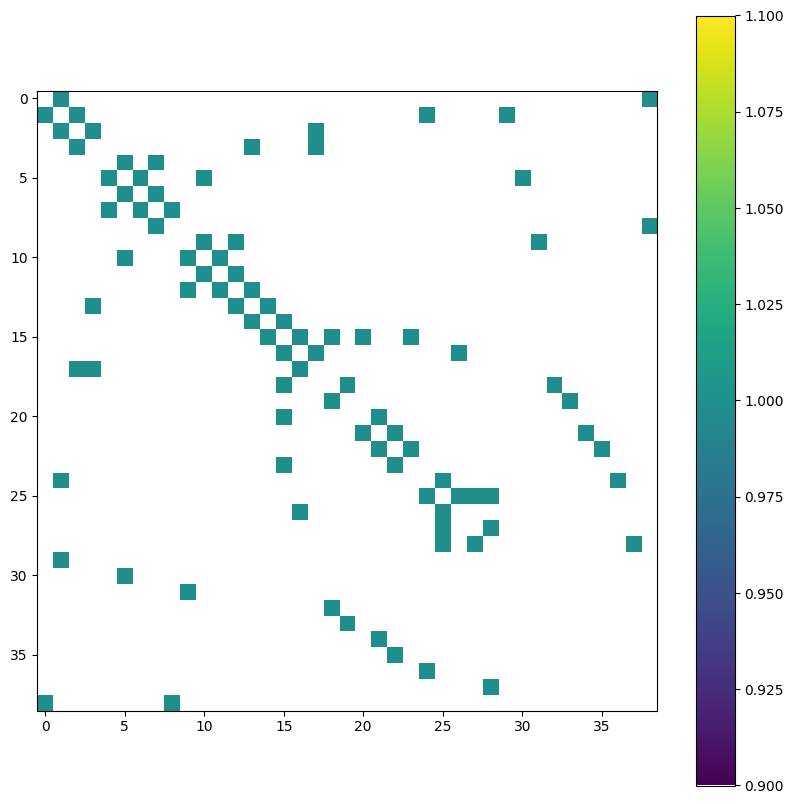

cost(pos,A,k)=np.float64(75.12234207202147)
cost(pos,A,k)=np.float64(66.6956697219947)
cost(pos,A,k)=np.float64(61.217762271237)
cost(pos,A,k)=np.float64(57.83124707995867)
cost(pos,A,k)=np.float64(54.55931050688562)
cost(pos,A,k)=np.float64(52.144188177287745)
cost(pos,A,k)=np.float64(49.69667098507163)
cost(pos,A,k)=np.float64(47.904267012594104)
cost(pos,A,k)=np.float64(45.73950674604839)
cost(pos,A,k)=np.float64(43.69537034495939)
cost(pos,A,k)=np.float64(41.784214040062984)
cost(pos,A,k)=np.float64(40.10273115440921)
cost(pos,A,k)=np.float64(38.380994246024414)
cost(pos,A,k)=np.float64(36.75296189673277)
cost(pos,A,k)=np.float64(35.28457828309453)
cost(pos,A,k)=np.float64(33.77893150009395)
cost(pos,A,k)=np.float64(32.646926520944284)
cost(pos,A,k)=np.float64(31.237091849546818)
cost(pos,A,k)=np.float64(30.09108863832582)
cost(pos,A,k)=np.float64(29.098982303996983)
cost(pos,A,k)=np.float64(28.287153511819774)
cost(pos,A,k)=np.float64(27.481612621055028)
cost(pos,A,k)=np.float64(2

[array([[ 6.7892909e-01, -5.6140136e-02],
        [ 8.9891809e-01, -1.7431779e-01],
        [ 9.1945815e-01,  2.1149360e-01],
        [ 7.3637575e-01,  4.2333773e-01],
        [-5.3772962e-01,  4.4612387e-01],
        [-4.4294614e-01,  4.3450797e-01],
        [-4.4612601e-01,  6.0252571e-01],
        [-2.3878631e-01,  4.3868226e-01],
        [ 1.0416420e-01,  2.8098783e-01],
        [-2.5344658e-01, -1.6374467e-01],
        [-4.1338196e-01,  8.9092717e-02],
        [-2.3650350e-01,  1.0285170e-03],
        [ 1.7992718e-02,  1.0673059e-01],
        [ 3.8252839e-01,  4.5692113e-01],
        [ 5.3042221e-01,  8.5164207e-01],
        [ 6.9003779e-01,  1.1891391e+00],
        [ 1.0021116e+00,  7.7751094e-01],
        [ 9.6700883e-01,  5.0928324e-01],
        [ 1.0687985e+00,  1.4438399e+00],
        [ 1.4141185e+00,  1.4973212e+00],
        [ 3.9779493e-01,  1.4746500e+00],
        [ 6.7764342e-02,  1.6136659e+00],
        [-9.0210207e-02,  1.4099910e+00],
        [ 2.7898297e-01,  1.314832

In [6]:
mat = getMatrixByName("bcspwr01")
print(mat.shape, mat.nnz, mat.dtype, np.min(mat.data), np.max(mat.data))

if scipy.sparse.issparse(mat):
    mat.setdiag(0)
    mat.eliminate_zeros()
    mat.data = np.abs(mat.data)
else:
    mat[np.diag_indices_from(mat)] = 0
    mat.data = np.abs(mat.data)

visMat(mat)


G = nx.Graph(mat)
for pos in spring_layout(G, method="FR_RS", iterations=50):
    visGraph(G, pos)

# for method in [
#     "circular_layout",
#     "kamada_kawai_layout",
#     "random_layout",
#     "shell_layout",
#     "spring_layout",
#     "spectral_layout",
#     "planar_layout",
#     "spiral_layout",
#     "arf_layout",
# ]:
#     print(method)
#     t0 = time.perf_counter()
#     pos = getattr(nx, method)(G)
#     print(f"{time.perf_counter() - t0:.3f} [sec]")
#     visGraph(G, pos)